In [2]:
# install datasets
!pip install datasets -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 2.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ibis-framework 7.1.0 requires pyarrow<15,>=2, but you have pyarrow 15.0.0 which is incompatible.


In [14]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
import datasets
import matplotlib
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Load database

In [4]:
# публичная ссылка на подготовленный ранее датасет, можно заменить на свою
url='https://drive.google.com/file/d/1-3MAwpJbztSND_3NbnSEW_g-XlfUDvtY/view?usp=sharing'
file_id=url.split('/')[-2]
dwn_url='https://drive.google.com/uc?id=' + file_id
talks_df = pd.read_pickle(dwn_url)
talks_df.sample(10)


,Season,Episode,speaker,query,companions,close_reply,neutral_reply,bad_reply,context
23217,3,2,Manager,May I help you find something?,"[Kyle, Manager, Kyle, Manager]","[Any what?, I need to get a nurection for my d...","[Yeah. Do you have any ""nurections""?, Excellen...","[Magic Camp? I don't know, bubbe, ask your fat...","Is this what you're looking for, Kyle?. No, I ..."
12062,16,11,Man,Hold on! Hold on!,"[Woman, Man, Woman, Announcer]","[I love you! I love you!, No! I love you! I lo...","[Oh I can't! I can't! I can't hold on!, We'll ...",[I'm making a dummy Ike doll. My parents think...,My dearest friends.I am living amongst the nat...
19136,2,3,Stan,"No, we just fake it to shut him up.","[Cartman, Barbrady, Cartman, Barbrady]","[Hooray!, Goody two-shoes., Swingset, swingset...","[God-dammit! , Oh God-dammit!, God-dammit!! Do...",[Hey! That kid took my last eraser! Come back...,How about a brain transplant? . Ahhh... O.... ...
6896,13,10,Cartman,"I might have to wait for my hepatitis test, bu...","[Announcer, Jimmy, Kenny, Kyle]","[What are you doing here, El, El Pollo Loco?, ...","[Dad!, Well, you see Butters, everything worke...","[Dude, I don't have time to start over with ot...",I served my country! I fought for two years in...
33523,6,1,Butters,"Yes, sir.","[Stephen, Reporter, Jimbo, Mayor McDaniels]","[Tom, I'm standing out in front of the Mayor's...","[Oh, huh- Don't you give us that look young ma...","[Ahhh, I think we'll stick with Kyle, dude. Yo...",Yes sir.. This is unbelievable! How many times...
18310,1,12,Kyle,Good!,"[Cartman, Kyle, Cartman, Kyle]","[Whoa!, Aaah! Aliens! , Aagh! Stop that!, Oh, ...","[Dad!, Well, you see Butters, everything worke...",[That's right. Kenny and I have been BFFs sinc...,What would we use a marble sack for?. Be caref...
36118,6,14,Kyle,"Hey guys, can we talk to you?","[Sheila, Sharon, Kyle, Sheila]","[How was school?, Uhh, not cool., That's great...","[Oh, hi boys., Oh, hi Stan., Oh, hi Eric.]","[Red Robin can be rented out, for wedding part...",I really enjoyed the imagery in the last chapt...
25431,3,11,Kyle,"Relax, fatass.","[Cartman, Stan, Cartman, Stan, Kyle]","[What??, Dude, I've seen it! They grab your ba...","[No. Dude, I've seen this on TV. They shine th...","[Yeah, I guess these passes the time-share sal...","No it wasn't, fatass! I saw you do it!. (Huh?)..."
1576,10,10,Cartman,"Yeah, well now it's personal! The hallways are...","[Ike, Cartman, Principal Victoria, Cartman]","[...And that's what I got, Principal brah. The...",[Atheism has definitely made our lives better....,"[No, dude, if something happens to him, my par...",They what??. They sneak out during class and m...
21874,2,13,Jimbo,"Hey, aren't those the people we at first thoug...","[Officer Barbrady, Mayor McDaniels, Jimbo, Off...","[Didn't we ever release them?, Aw, I forgot al...","[Yeah., Yeah., Yeah.]","[Tsst. , It's okay, Mom. I understand., That's...","I hope so, Mayor. I hope so. Uhud I need a col..."


In [5]:
# Соберем все ответы из базы
base_answers = talks_df['close_reply'].values
all_replies = []
for rep in base_answers.tolist():
  all_replies.extend(rep)
all_replies = list(set(all_replies)) # Список всех ответов из базы

#  Bi-Encoder и Cross-Encoder реранкинг для Retrieval-систем

In [6]:
from typing import Callable, Iterable

import torch
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import AutoTokenizer, AutoModel
from transformers.optimization import get_linear_schedule_with_warmup
from scipy import stats
from sklearn.metrics.pairwise import cosine_similarity

In [8]:
SEED = 10

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

## tokenized_texts

## Training Cross-Encoder

In [10]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
dir = "/content/drive/Othercomputers/My_comp/Документы/МФТИ_Наука_о_данных/NLP_generation/DZ/DZ_1/Project/models"
bert_model = AutoModel.from_pretrained("distilbert-base-uncased")
bert_model.from_pretrained(dir + "/sbert_softmax_lr_0.0")

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Li

In [11]:
# example of next sentence prediction objective used for a cross encoder
tokenized_texts = tokenizer(["I am hungry."], ["Order some food for me"], padding=True, truncation=True)
tokenizer.decode(tokenized_texts["input_ids"][0])

'[CLS] i am hungry. [SEP] order some food for me [SEP]'

In [12]:
tokenized_texts

{'input_ids': [[101, 1045, 2572, 7501, 1012, 102, 2344, 2070, 2833, 2005, 2033, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

Для нашей задачи возьмем датасет с парами предложений, которые размечены на задачу Semantic Textual Similarity - то есть решается задача, насколько они похожи в семантическом смысле

In [15]:
dataset = datasets.load_dataset("glue", "stsb", split="train")
len(dataset), dataset[0]

Generating train split:   0%|          | 0/5749 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1379 [00:00<?, ? examples/s]

(5749,
 {'sentence1': 'A plane is taking off.',
  'sentence2': 'An air plane is taking off.',
  'label': 5.0,
  'idx': 0})

In [16]:
text_lengths1, text_lengths2 = [], []
for data in tqdm(dataset):
    if random.random() > 0.5:
        text_lengths1.append(len(data["sentence1"]))
        text_lengths2.append(len(data["sentence2"]))

100%|██████████| 5749/5749 [00:00<00:00, 19041.74it/s]


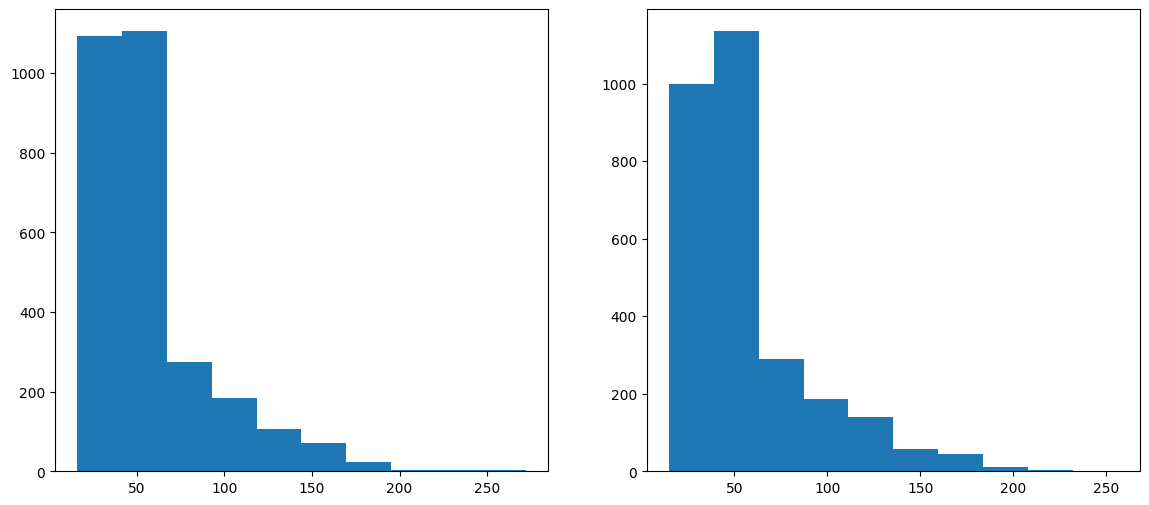

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0].hist(text_lengths1)
ax[1].hist(text_lengths2);

In [18]:
%%time

MAX_LENGTH = 128

tokenized_texts = tokenizer([data["sentence1"] for data in dataset],
                            [data["sentence2"] for data in dataset],
                            max_length=MAX_LENGTH, padding="max_length",
                            truncation=True, verbose=True)

CPU times: user 1.39 s, sys: 101 ms, total: 1.49 s
Wall time: 1.01 s


Создадим самый простой датасет для данной задачи

In [19]:
class StsDataset(Dataset):
    def __init__(self, tokens: dict, labels: list[float]):
        self.tokens = tokens
        self.labels = labels

    def __getitem__(self, ix: int) -> dict[str, torch.tensor]:
        return {
            "input_ids": torch.tensor(self.tokens["input_ids"][ix], dtype=torch.long),
            "attention_mask": torch.tensor(self.tokens["attention_mask"][ix], dtype=torch.long),
            "labels": torch.tensor(self.labels[ix], dtype=torch.float)  # Use float for regression
        }

    def __len__(self) -> int:
        return len(self.tokens["input_ids"])


In [20]:
%%time

sts_dataset = StsDataset(tokenized_texts, [data["label"] for data in dataset])

CPU times: user 189 ms, sys: 2.57 ms, total: 192 ms
Wall time: 190 ms


In [21]:
train_ratio = 0.8
n_total = len(sts_dataset)
n_train = int(n_total * train_ratio)
n_val = n_total - n_train

train_dataset, val_dataset = random_split(sts_dataset, [n_train, n_val])

batch_size = 16  # mentioned in the paper
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
len(train_dataloader), len(val_dataloader)

(288, 72)

Mодель должна включать в себя BERT-like модель и поверх нее должен стоять линейный слой.
Метод forward должен включать в себя получение CLS-эмбединга от BERT-like модели и передачаа его на линейный слой

In [22]:
class CrossEncoderBert(torch.nn.Module):
    def __init__(self, max_length: int = MAX_LENGTH):
        super().__init__()
        self.max_length = max_length
        self.bert_model = AutoModel.from_pretrained('distilbert-base-uncased')
        self.bert_tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
        self.linear = torch.nn.Linear(self.bert_model.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert_model(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0]  # Use the CLS token's output
        return self.linear(pooled_output)

In [23]:
model = CrossEncoderBert().to(DEVICE)

Используем MSE loss потому что по сути решаем задачу регрессии, но вы можете придумать что-то более сложное

In [24]:
#  optimizer, lr, num_warmup steps have been picked from the paper
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5)
total_steps = len(train_dataset) // batch_size
warmup_steps = int(0.1 * total_steps)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps,
                                            num_training_steps=total_steps - warmup_steps)

loss_fn = torch.nn.MSELoss()

In [27]:
def train_step_fn(model, optimizer, scheduler, loss_fn, batch):
    model.train()
    input_ids = batch['input_ids'].to(DEVICE)
    attention_mask = batch['attention_mask'].to(DEVICE)
    labels = batch['labels'].to(DEVICE)
    optimizer.zero_grad()
    logits = model(input_ids, attention_mask)
    loss = loss_fn(logits.squeeze(-1), labels)
    loss.backward()
    optimizer.step()
    scheduler.step()
    return loss.item()

def val_step_fn(model, loss_fn, batch):
    model.eval()
    input_ids = batch['input_ids'].to(DEVICE)
    attention_mask = batch['attention_mask'].to(DEVICE)
    labels = batch['labels'].to(DEVICE)
    with torch.no_grad():
        logits = model(input_ids, attention_mask)
    loss = loss_fn(logits.squeeze(-1), labels)
    return loss.item()

def mini_batch(dataloader, step_fn, is_training=True):
    mini_batch_losses = []
    for i, batch in enumerate(dataloader):
        if is_training:
            loss = step_fn(model, optimizer, scheduler, loss_fn, batch)
        else:
            loss = step_fn(model, loss_fn, batch)
        mini_batch_losses.append(loss)
        if i % (batch_size * 4) == 0:
            print(f"Step {i:>5}/{len(dataloader)}, Loss = {loss:.3f}")
    return np.mean(mini_batch_losses), mini_batch_losses

Запустим обучение нашей модели

In [28]:
%%time

n_epochs = 5

train_losses, train_mini_batch_losses = [], []
val_losses, val_mini_batch_losses = [], []

for epoch in range(1, n_epochs + 1):
    print(f"\nEpoch {epoch}")
    train_loss, _train_mini_batch_losses = mini_batch(train_dataloader, train_step_fn, is_training=True)
    train_mini_batch_losses.extend(_train_mini_batch_losses)
    train_losses.append(train_loss)

    with torch.no_grad():
        val_loss, _val_mini_batch_losses = mini_batch(val_dataloader, val_step_fn, is_training=False)
        val_mini_batch_losses.extend(_val_mini_batch_losses)
        val_losses.append(val_loss)


Epoch 1
Step     0/288, Loss = 7.047
Step    64/288, Loss = 1.589
Step   128/288, Loss = 0.352
Step   192/288, Loss = 0.987
Step   256/288, Loss = 0.783
Step     0/72, Loss = 0.960
Step    64/72, Loss = 0.380

Epoch 2
Step     0/288, Loss = 0.778
Step    64/288, Loss = 0.613
Step   128/288, Loss = 0.862
Step   192/288, Loss = 0.329
Step   256/288, Loss = 0.351
Step     0/72, Loss = 0.960
Step    64/72, Loss = 0.380

Epoch 3
Step     0/288, Loss = 0.514
Step    64/288, Loss = 0.752
Step   128/288, Loss = 0.477
Step   192/288, Loss = 0.218
Step   256/288, Loss = 0.623
Step     0/72, Loss = 0.960
Step    64/72, Loss = 0.380

Epoch 4
Step     0/288, Loss = 0.482
Step    64/288, Loss = 0.983
Step   128/288, Loss = 0.445
Step   192/288, Loss = 0.358
Step   256/288, Loss = 0.967
Step     0/72, Loss = 0.960
Step    64/72, Loss = 0.380

Epoch 5
Step     0/288, Loss = 0.747
Step    64/288, Loss = 0.883
Step   128/288, Loss = 0.607
Step   192/288, Loss = 0.273
Step   256/288, Loss = 0.343
Step  

In [29]:
window_size = 32

train_mb_running_loss = []
for i in range(len(train_mini_batch_losses)-window_size):
    train_mb_running_loss.append(np.mean(train_mini_batch_losses[i:i+window_size]))

val_mb_running_loss = []
for i in range(len(val_mini_batch_losses)-window_size):
    val_mb_running_loss.append(np.mean(val_mini_batch_losses[i:i+window_size]))

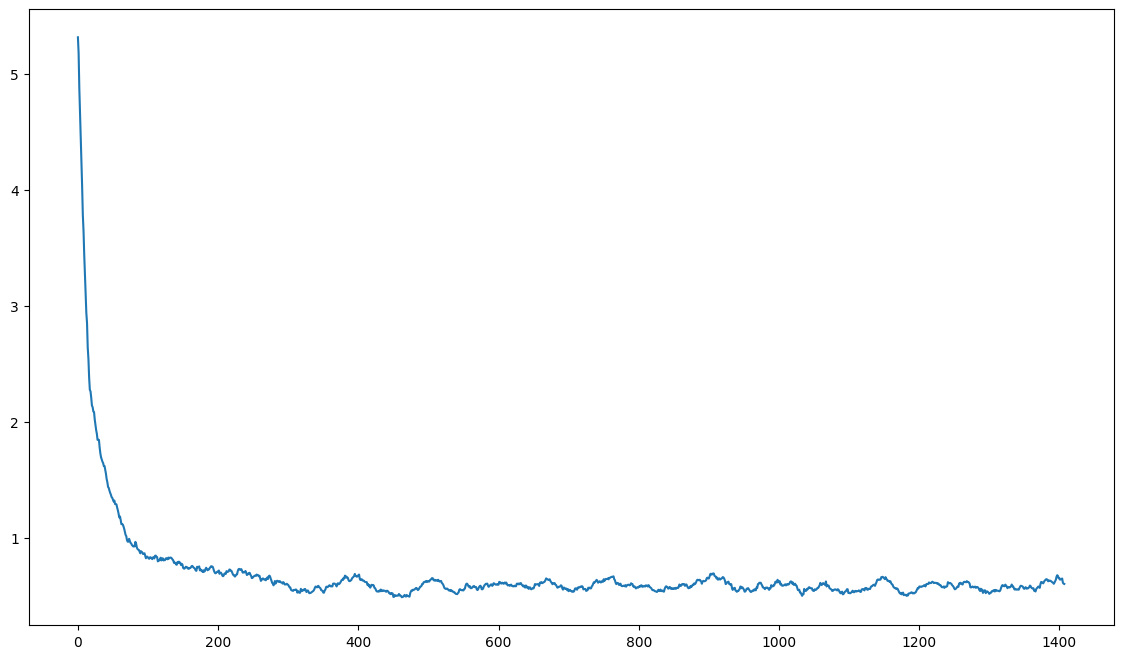

In [30]:
fix, ax = plt.subplots(figsize=(14, 8))
ax.plot(range(len(train_mb_running_loss)), train_mb_running_loss);

In [57]:
dir = "/content/drive/Othercomputers/My_comp/Документы/МФТИ_Наука_о_данных/NLP_generation/DZ/DZ_1/Project/models"
model.bert_model.save_pretrained(dir + "/cross_ecoder_5ep")

Напишем функцию ранжирующую условную текстовую выдачу

In [31]:
def get_ranked_docs(
    tokenizer: AutoTokenizer, finetuned_ce: CrossEncoderBert,
    base_bert: AutoModel, query: str, corpus: list[str]
) -> None:

    queries = [query] * len(corpus)
    tokenized_texts = tokenizer(
        queries, corpus, max_length=MAX_LENGTH, padding=True, truncation=True, return_tensors="pt"
    ).to(DEVICE)

    # Finetuned CrossEncoder model scoring
    with torch.no_grad():
        ce_scores = finetuned_ce(tokenized_texts['input_ids'], tokenized_texts['attention_mask']).squeeze(-1)
        ce_scores = torch.sigmoid(ce_scores)  # Apply sigmoid if needed

    # Base Bert model scoring
    with torch.no_grad():
        base_bert_outputs = base_bert(**tokenized_texts)
        bert_scores = torch.sigmoid(finetuned_ce.linear(base_bert_outputs.last_hidden_state[:, 0, :]))  # Use CLS token output

    # Process scores for finetuned model
    print(f"Query - {query} [Finetuned Cross-Encoder]\n---")
    scores = ce_scores.cpu().numpy()
    scores_ix = np.argsort(scores)[::-1]
    for ix in scores_ix:  # Limit to corpus size
        print(f"{scores[ix]: >.2f}\t{corpus[ix]}")

    # Process scores for base Bert model
    print(f"\nQuery - {query} [Bert Base]\n---")
    scores = bert_scores.cpu().numpy().squeeze(-1)
    scores_ix = np.argsort(scores)[::-1]
    for ix in scores_ix:  # Limit to corpus size
        print(f"{scores[ix]: >.2f}\t{corpus[ix]}")

In [32]:
corpus = [
    "A man is eating food.",
    "A man is eating a piece of bread.",
    "The girl is carrying a baby.",
    "A man is riding a horse.",
    "A woman is playing violin.",
    "Two men pushed carts through the woods.",
    "A man is riding a white horse on an enclosed ground.",
    "A monkey is playing drums.",
    "A cheetah is running behind its prey."
]

query = "A man is eating pasta."

In [33]:
get_ranked_docs(tokenizer, model, bert_model.to(DEVICE), query, corpus)

Query - A man is eating pasta. [Finetuned Cross-Encoder]
---
0.94	A man is eating food.
0.87	A man is eating a piece of bread.
0.59	A man is riding a horse.
0.56	A man is riding a white horse on an enclosed ground.
0.53	A cheetah is running behind its prey.
0.51	The girl is carrying a baby.
0.50	Two men pushed carts through the woods.
0.50	A woman is playing violin.
0.48	A monkey is playing drums.

Query - A man is eating pasta. [Bert Base]
---
0.47	A man is riding a horse.
0.47	The girl is carrying a baby.
0.47	A cheetah is running behind its prey.
0.47	A woman is playing violin.
0.47	A monkey is playing drums.
0.47	A man is eating food.
0.47	Two men pushed carts through the woods.
0.47	A man is riding a white horse on an enclosed ground.
0.47	A man is eating a piece of bread.


# Тест ответов

In [44]:
def flush_memory():
    import gc
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()
    with torch.no_grad():
        for _ in range(3):
          torch.cuda.empty_cache()
          torch.cuda.ipc_collect()



In [52]:
def get_best_rand_reply(
    tokenizer: AutoTokenizer,
    finetuned_ce: CrossEncoderBert,
    base_bert: AutoModel,
    query: str,
    context: str,
    corpus: list[str],
    size_patch = 150,
    qty_rand_choose = 5,
    max_out_context = 200
) -> None:

    dic_answ = dict()
    dic_answ["score"] = []
    dic_answ["answer"] = []

    conext_memory= query+"[SEP]"+context

    if len(corpus) < qty_rand_choose*max_out_context:
       qty_rand_choose = int(len(corpus))

    # так как база большая
    for i in range(qty_rand_choose):
        rand_patch_corpus = list(np.random.choice(corpus, size_patch))
        #print(len(rand_patch_corpus))

        queries = [conext_memory]* len(rand_patch_corpus)
        #print(len(queries))
        tokenized_texts = tokenizer(
            queries,
            rand_patch_corpus,
            max_length=MAX_LENGTH,
            padding=True,
            truncation=True,
            return_tensors="pt"
        ).to(DEVICE)

        # Finetuned CrossEncoder model scoring
        with torch.no_grad():
            ce_scores = finetuned_ce(tokenized_texts['input_ids'],
                                     tokenized_texts['attention_mask']).squeeze(-1)
            ce_scores = torch.sigmoid(ce_scores)  # Apply sigmoid if needed

        # Process scores for finetuned model
        scores = ce_scores.cpu().numpy()
        scores_ix = np.argsort(scores)[::-1][0]
        dic_answ["score"].append(scores[scores_ix])
        dic_answ["answer"].append(rand_patch_corpus[scores_ix])

    id = np.argsort(dic_answ["score"])[::-1][0]# np.array(dic_answ["score"]).argmax()
    answer = dic_answ["answer"][id]
    conext_memory = answer+"[SEP]"+conext_memory
    flush_memory()
    return answer, conext_memory[:max_out_context], dic_answ["score"][id]


## Вопрос ответ

In [54]:
question = "What is the live?"  #
print(f"Реплика: {question}")

best_answer, conext_memory,  best_score = get_best_rand_reply(
    tokenizer, model, bert_model.to(DEVICE),
    query = question,
    context = "",
    corpus = all_replies)

print(f"Лучший ответ: {best_answer}\nscore {best_score}")


Реплика: What is the live?
Лучший ответ: You guys! Um, dum dumdumdum, dumdum, dumdum. Can't touch this. Dum dumdumdum, dumdum, dumdum. Can't touch this.
score 0.9787939786911011


## Иммитация беседы с контекстом

In [56]:
rand_questions = talks_df.sample(10)['query'].values

for i, question in enumerate(rand_questions):
  print(f"Реплика: {question}")
  if not i: conext_memory = ""
  best_answer, conext_memory,  best_score = get_best_rand_reply(
                              tokenizer, model, bert_model.to(DEVICE),
                              query = question,
                              context = conext_memory,
                              corpus = all_replies)
  best_score = round(float(best_score), 3)
  print(f"Ответ: {best_answer}\n score {best_score}\n")


Реплика: You know the feeling when the huge dump you just took shoots back up inside your ass? NO I"M NOT ALL RIGHT!!
Ответ: Now-uh, let's focus our discussion first on marijawana.  Marijawana's bad, and it also has a very distinct smell, okay? I'm gonna pass around just a little tiny bit. Now, I want you all to take a smell,  so you know when someone is smoking marijawana near you. M'kay, just take a smell, pass it on,  and when it gets back up to me,  we'll finish talking about it. In the meantime, I want to get into alcohol a little, okay? Uh, alcohol is bad. Uh, if you drink alcohol you…
 score 0.962

Реплика: What are you saying?!
Ответ: Crème fraîche. Crème fraîche.  Where is it?! Where is it?!  Dammit, where is that crème fraîche?!  Where did I leave that fucking crème fraîche?! It has to be somewhere!
 score 0.963

Реплика: Take me away to that special place (that blowjob place)Where people like us can all live free (Free to give blowjobs)Take me away and let's live togetherTha